In [1]:
from SimPEG import *
from simpegEM1D import (
    simulation, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from simpegEM1D import skytem_HM_2015
time = np.logspace(-5, -2, 31)
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10., n_layer=19)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'stepoff',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time,
    base_frequency = 25.,
    use_lowpass_filter=False,
    high_cut_frequency=210*1e3        
)
sig_half = 1e-1
sig_blk = sig_half * 20.
chi_half = 0.
expmap = maps.ExpMap(mesh1D)

In [3]:
# two_layer_map = TwoLayerMap(mesh, logSigma=True)


In [4]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (-30>LocSigZ) & (-70<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

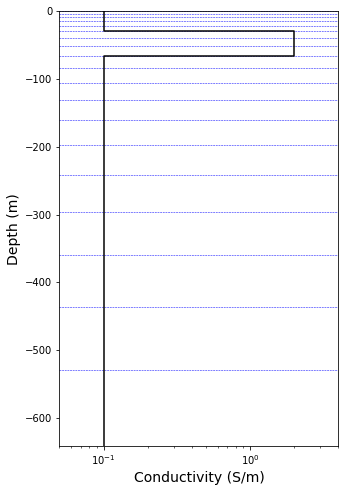

In [5]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=True)

In [6]:
%%time
sim = simulation.EM1DTMSimulation(mesh1D, survey=TDsurvey, sigmaMap=expmap, verbose=False)
sim.chi = np.zeros(TDsurvey.n_layer)
d_true = sim.dpred(m_true)

Wall time: 87.7 ms


In [7]:
TDsurvey.frequency.shape

(116,)

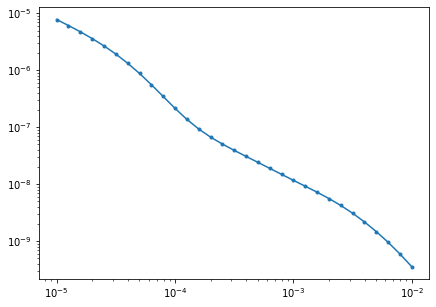

In [8]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, '.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [9]:
np.random.seed(1)
std = 0.05
noise = std*abs(d_true)*np.random.randn(len(d_true))
d_obs = d_true + noise
floor = 0.
std = 0.07
uncert = abs(d_obs)*std+floor
dataObj = data.Data(TDsurvey, dobs=d_obs, noise_floor=uncert)

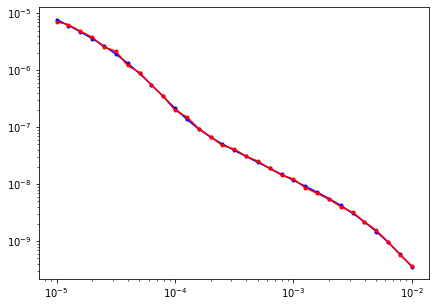

In [10]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, 'b.-')
axes.plot(TDsurvey.time, -d_obs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [11]:
dmisfit = data_misfit.L2DataMisfit(dataObj, sim)
dmisfit.W = utils.sdiag(1/uncert)

In [12]:
m0 = np.log(np.ones_like(sig)*sig_half)
d_0 = sim.dpred(m0)
# delta = prob.get_threshold(uncert)

In [13]:
reg = regularization.Sparse(
    mesh1D,
    mapping=maps.IdentityMap(mesh1D),
    alpha_s=1.,
    alpha_x=1.
)
p = 0
qx, qz = 2., 2.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = directives.Update_IRLS(
    max_irls_iterations=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2,
    chifact_start = 1.
)
opt = optimization.ProjectedGNCG(maxIter = 25)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = directives.TargetMisfit()
# update_sense = Directives.UpdateSensitivityWeights(threshold=delta)
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
# prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [14]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.43e+00  1.16e+03  0.00e+00  1.16e+03    4.82e+02      0              
   1  1.21e+00  5.74e+02  4.35e+01  6.27e+02    1.84e+02      0              
   2  6.07e-01  8.45e+01  1.56e+02  1.79e+02    9.70e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.1626e+02
0 : |xc-x_last| = 1.6377e+00 <= tolX*(1+|x0|) = 1.1037e+00
0 : |proj(x-g)-x|    = 9.6958e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 9.6958e+01 <= 1e3*eps       = 1

In [15]:
# opt.counter.summary()
# xc = opt.recall('xc')

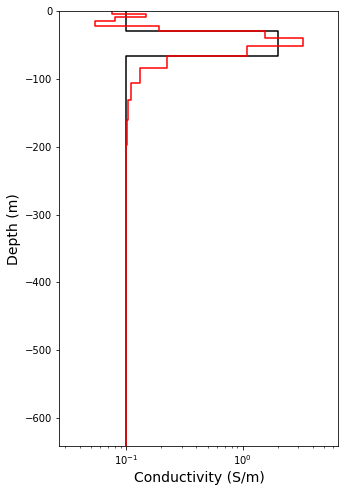

In [16]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D)
Utils1D.plotLayer(expmap*mopt, mesh1D, showlayers=False, **{'color':'r'})
# Utils1D.plotLayer(expmap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1.})

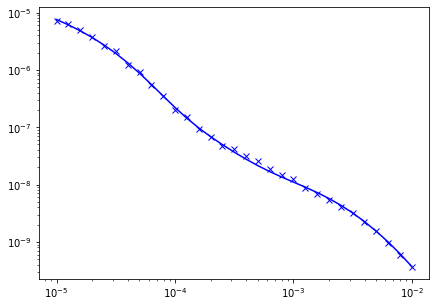

In [17]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
axes.plot(TDsurvey.time, -d_obs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');